In [1]:
%cd ..

/Users/arian/Desktop/OptiServe


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import boto3
import datetime
import os

from src.analytics.aws_function_logs import AWSFunctionLogs
from src.profiler.explorer import Explorer
from src.profiler.cost_calculator import CostCalculator
from src.optimizer.parametric_function import ParamFunction

from src.modeling.function_performance_modeling import FunctionPerformanceModeling

In [3]:
payload = "{}"
region_name = 'us-east-1'
memory_bound = (128, 3008)
functions = [
    'f1',
    'f2',
    'f3',
    'f4',
    'f5',
    'f6',
]

memory_space_step = 64

In [ ]:
# Exctracting performance models for a set of functions

for function_name in functions:
    p_model = FunctionPerformanceModeling(function_name=function_name, payload=payload, memory_bounds=memory_bound, profiling_iterations=3)
    p_model = p_model.get_performance_model()
    p_model.save('modeled_functions/' + function_name + '.mdl')

Explored memories: [ 128  128  128 1088 1088 1088 3007 3007 3007]
Sample Count:  9
Max Sample Count:  20
Memories:  [ 128  128  128 1088 1088 1088 3007 3007 3007]
Duration:  [3057. 3081. 3142.  328.  329.  326.  248.  250.  263.]
Value and Threshold:  1.9848267910834787 3
Sample Count:  12
Max Sample Count:  20
Memories:  [ 128  128  128 1088 1088 1088 1599 1599 1599 3007 3007 3007]
Duration:  [3057. 3081. 3142.  328.  329.  326.  241.  232.  243.  248.  250.  263.]
Value and Threshold:  2.042698086498286 3
Sample Count:  15
Max Sample Count:  20
Memories:  [ 128  128  128  674  674  674 1088 1088 1088 1599 1599 1599 3007 3007
 3007]
Duration:  [3057. 3081. 3142.  536.  537.  574.  328.  329.  326.  241.  232.  243.
  248.  250.  263.]
Value and Threshold:  2.183915216121444 3
Sample Count:  18
Max Sample Count:  20
Memories:  [ 128  128  128  674  674  674 1088 1088 1088 1599 1599 1599 2112 2112
 2112 3007 3007 3007]
Duration:  [3057. 3081. 3142.  536.  537.  574.  328.  329.  326.  2

In [4]:
# Loading the performance models

p_models_dir = "modeled_functions"

p_models = [ParamFunction.load(f"{p_models_dir}/{function_name}.mdl") for function_name in functions]

In [ ]:
# Exploring all the possible memory configurations performance

for function_name in functions:
    print(f"Exploring function: {function_name}")
    explorer = Explorer(
        function_name=function_name,
        payload=payload,
        boto_session=boto3.Session(region_name=region_name),
        memory_space_step=memory_space_step,
        max_invocations=5
    )  
    explorer.explore_all_memories(num_of_invocations=10)
    del explorer
    print(f"Exploration completed for function: {function_name}\n")

Exploring function: f1


Processing: 100%|██████████ [Elapsed: 05:39 | Remaining: 00:00]


Exploration completed for function: f1

Exploring function: f2


Processing: 100%|██████████ [Elapsed: 05:28 | Remaining: 00:00]


Exploration completed for function: f2

Exploring function: f3


Processing: 100%|██████████ [Elapsed: 05:10 | Remaining: 00:00]


Exploration completed for function: f3

Exploring function: f4


Processing: 100%|██████████ [Elapsed: 05:42 | Remaining: 00:00]


Exploration completed for function: f4

Exploring function: f5


Processing: 100%|██████████ [Elapsed: 05:06 | Remaining: 00:00]


Exploration completed for function: f5

Exploring function: f6


Processing: 100%|██████████ [Elapsed: 07:05 | Remaining: 00:00]

Exploration completed for function: f6



In [7]:
logs_dir = "logs"
os.makedirs(logs_dir, exist_ok=True)

In [ ]:
# Extracting the logs

for function_name in functions:
    df = AWSFunctionLogs(
        boto_session=boto3.Session(region_name=region_name),
        function_name=function_name,
    ).get_logs_df(start_time=int((datetime.datetime.utcnow() - datetime.timedelta(days=30)).timestamp()),
        end_time=int(datetime.datetime.utcnow().timestamp()))

    df.to_csv(f'{logs_dir}/{function_name}_logs.csv')

In [8]:
cost_calculator = CostCalculator()

In [9]:
dfs = [pd.read_csv(f'{logs_dir}/{function_name}_logs.csv') for function_name in functions]

In [10]:
logs_list = []

for df in dfs:
    logs = df[df['Init Duration'].isna()]

    logs = logs.groupby('Memory Size').agg({
        'Duration': 'mean',
    }).reset_index()

    if 'Duration' in logs.columns and 'Memory Size' in logs.columns:
        logs.loc[:, 'Cost'] = logs.apply(
            lambda row: cost_calculator.calculate_cost(
                memory_mb=row['Memory Size'],
                duration_ms=row['Duration']
            ),
            axis=1
        )
    logs_list.append(logs)


In [12]:
memory_space = np.arange(memory_bound[0], memory_bound[1] + 1)

for i, logs in enumerate(logs_list):
    logs_list[i] = logs[logs['Memory Size'].isin(memory_space)]


modeled_durations = []
modeled_costs = []

for p_model in p_models:

    m_duration = []
    m_cost = []

    for memory in memory_space:
        t = p_model(memory)
        m_duration.append(t)
        m_cost.append(cost_calculator.calculate_cost(memory_mb=memory, duration_ms=t))

    m_duration = np.array(m_duration)
    m_cost = np.array(m_cost)
    
    modeled_durations.append(m_duration)
    modeled_costs.append(m_cost)

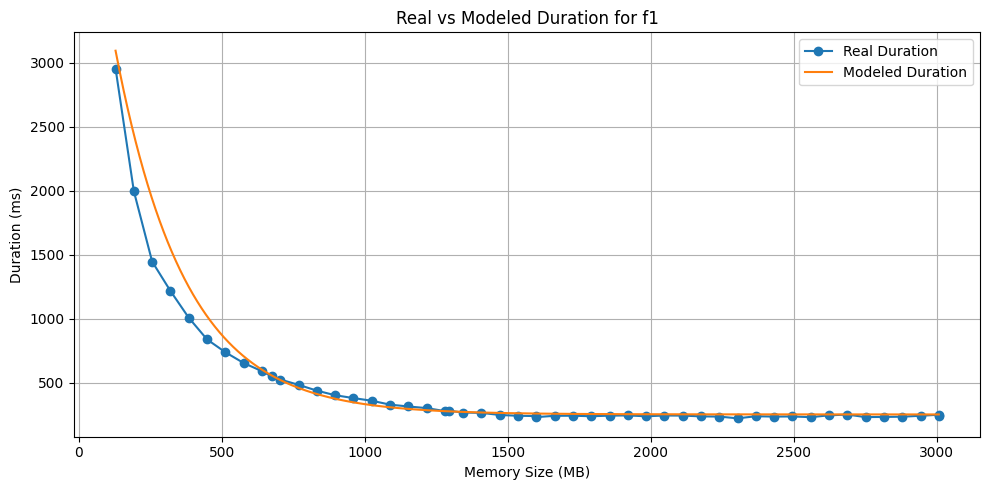

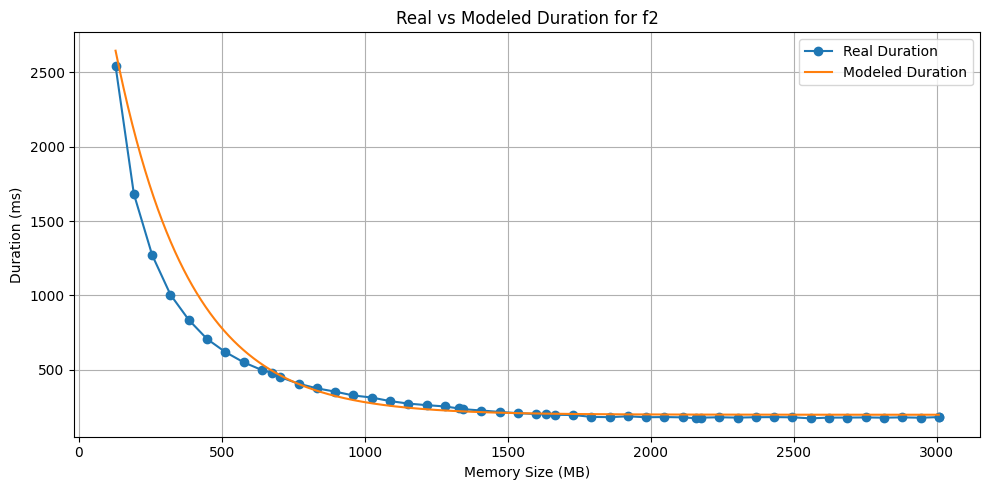

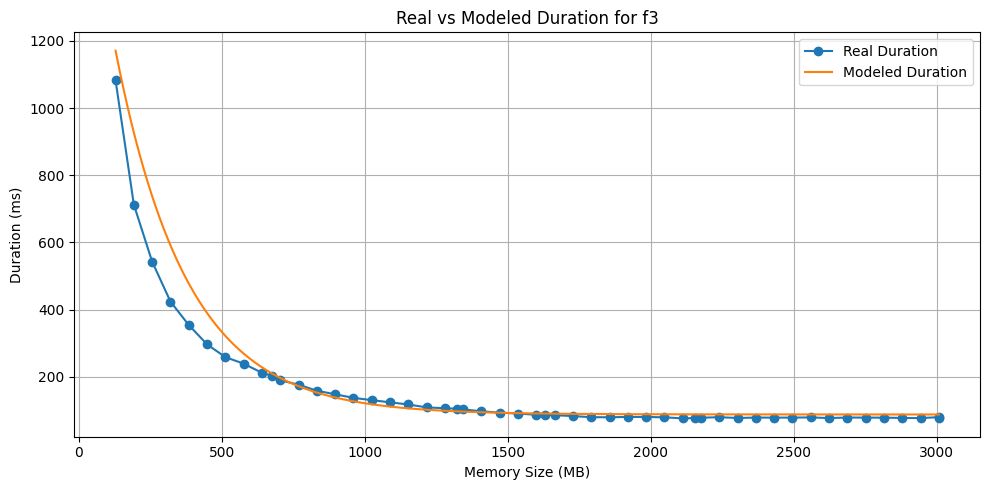

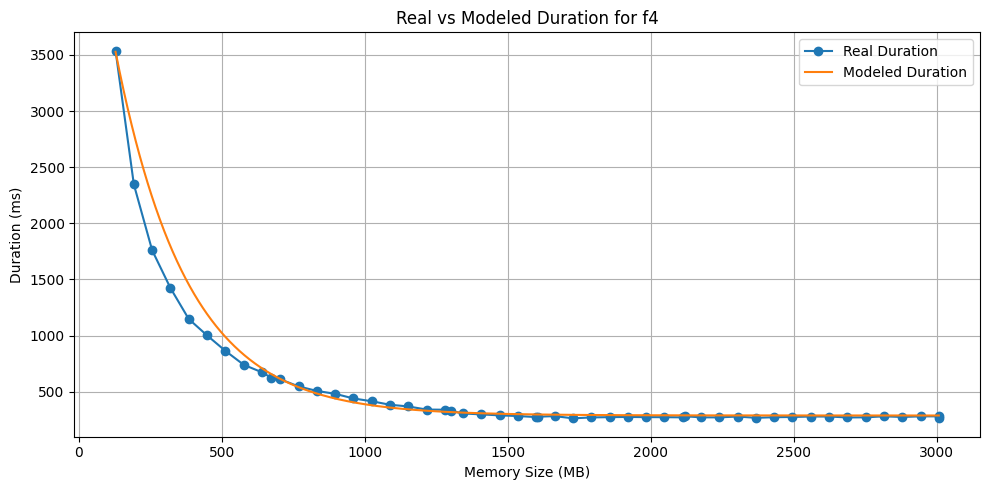

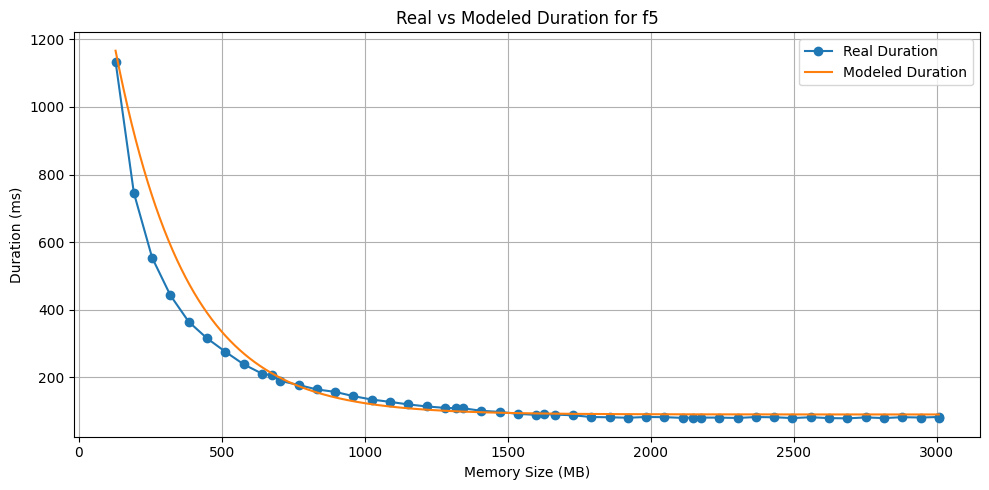

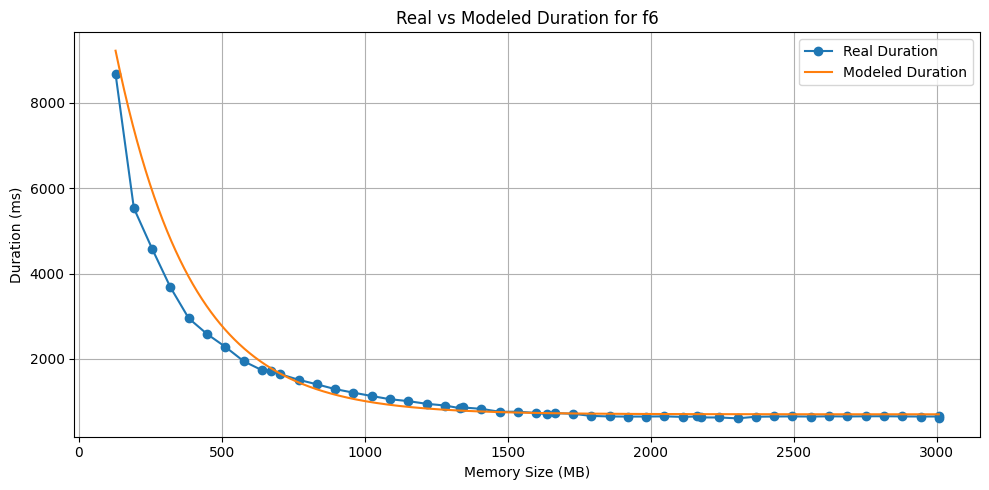

In [14]:
# Real vs Modeled Duration
for i, function_name in enumerate(functions):
    plt.figure(figsize=(10, 5))
    plt.plot(logs_list[i]['Memory Size'], logs_list[i]['Duration'], label='Real Duration', marker='o')
    plt.plot(memory_space, modeled_durations[i], label='Modeled Duration')
    plt.xlabel('Memory Size (MB)')
    plt.ylabel('Duration (ms)')
    plt.title(f'Real vs Modeled Duration for {function_name}')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show(block=False)

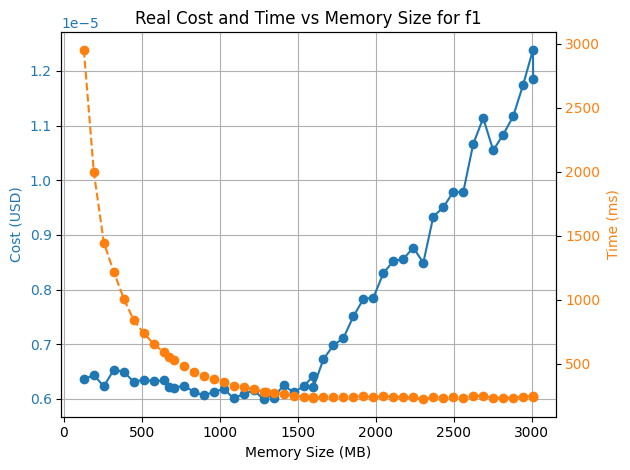

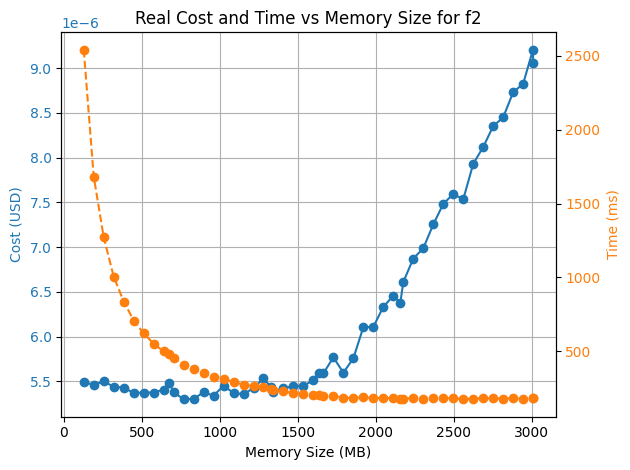

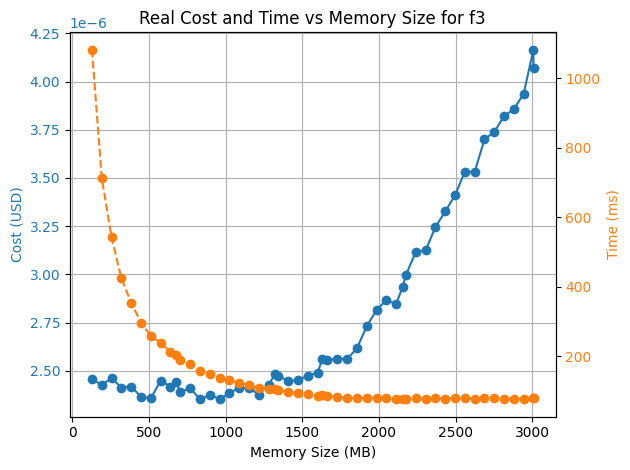

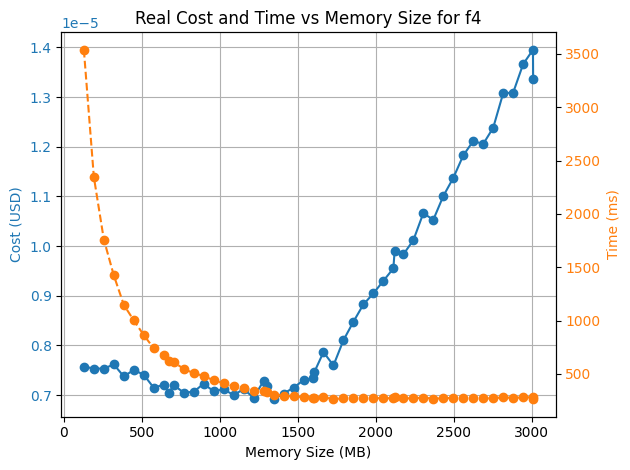

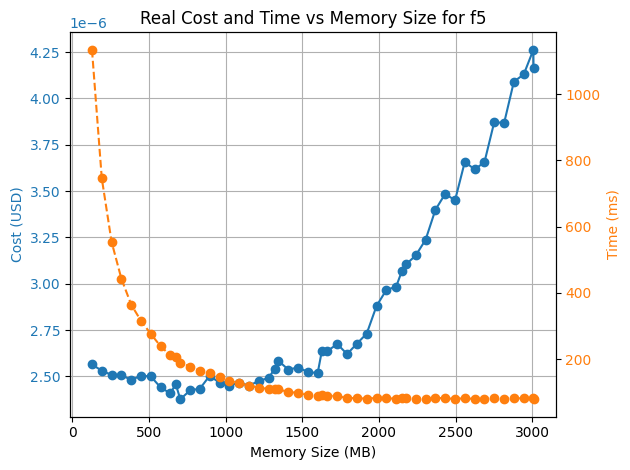

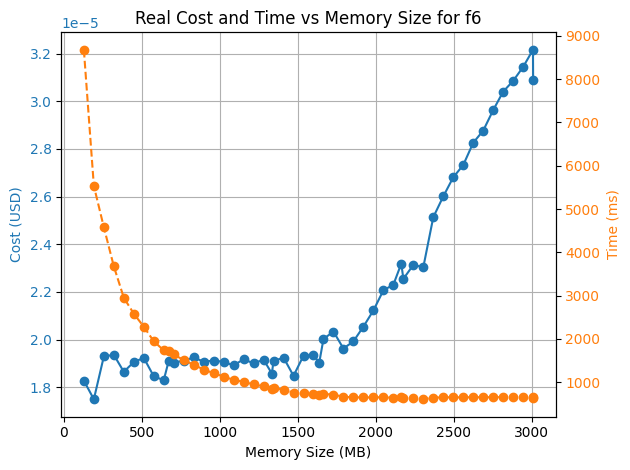

In [15]:
for i, function_name in enumerate(functions):
    # Create figure and axis objects
    fig, ax1 = plt.subplots()

    # Plot Cost on the primary y-axis
    ax1.set_xlabel('Memory Size (MB)')
    ax1.set_ylabel('Cost (USD)', color='tab:blue')
    ax1.plot(logs_list[i]['Memory Size'], logs_list[i]['Cost'], color='tab:blue', marker='o', label='Cost')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Create a second y-axis for Time
    ax2 = ax1.twinx()
    ax2.set_ylabel('Time (ms)', color='tab:orange')
    ax2.plot(logs_list[i]['Memory Size'], logs_list[i]['Duration'], color='tab:orange', marker='o', linestyle='--', label='Time')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # Add a title and grid
    plt.title('Real Cost and Time vs Memory Size for ' + function_name)
    ax1.grid(True)

    # Show plot
    plt.tight_layout()
    plt.show(block=False)

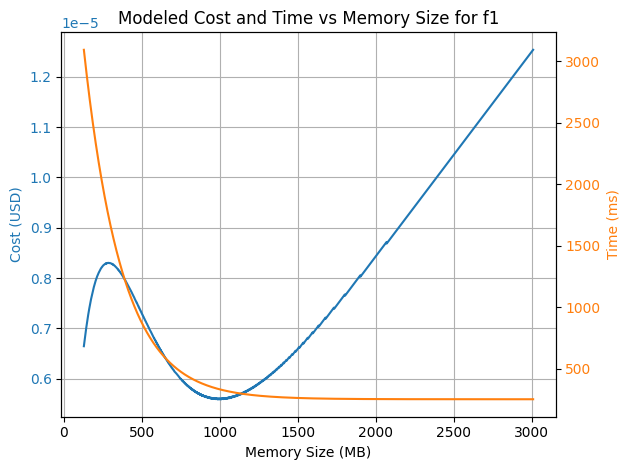

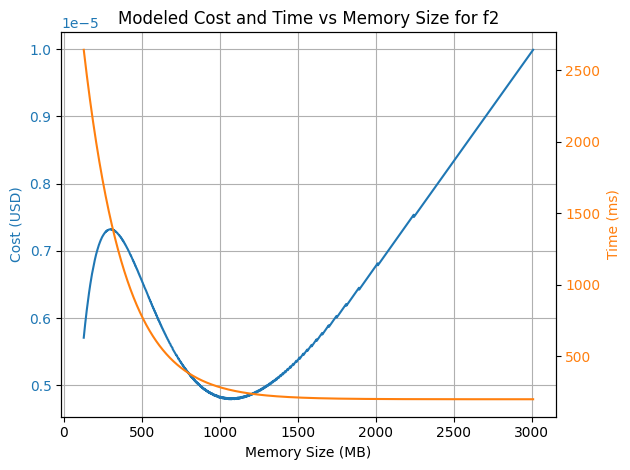

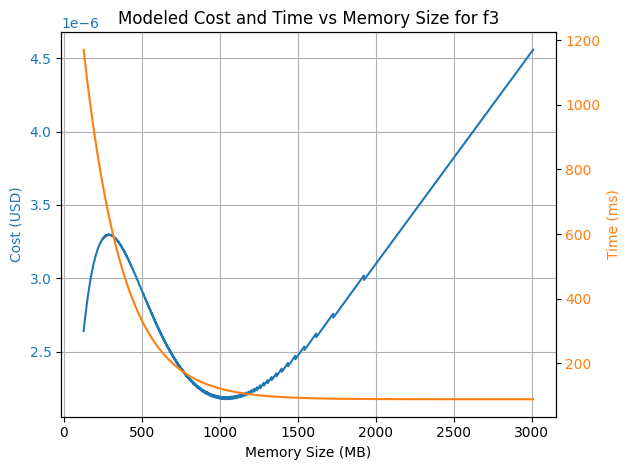

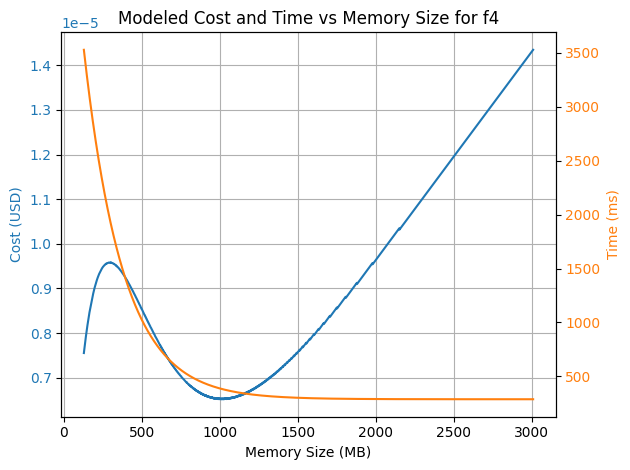

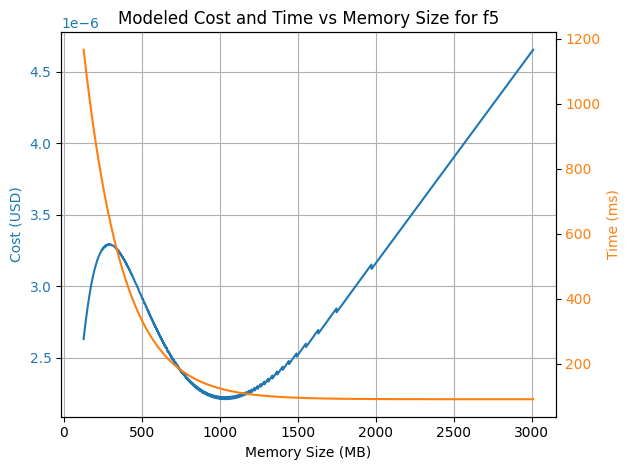

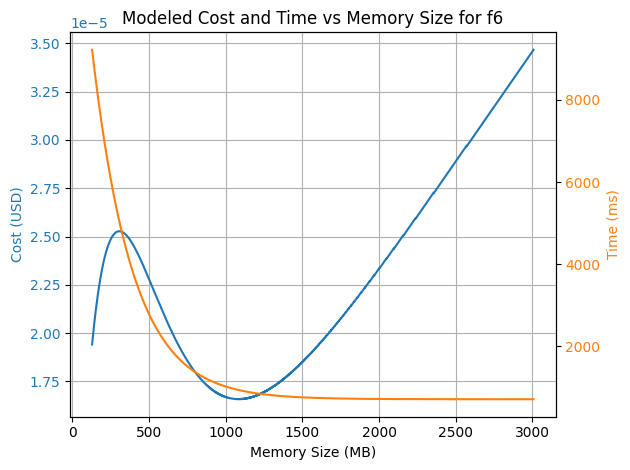

In [16]:
for i, function_name in enumerate(functions):
    # Create figure and axis objects
    fig, ax1 = plt.subplots()


    # Plot Cost on the primary y-axis
    ax1.set_xlabel('Memory Size (MB)')
    ax1.set_ylabel('Cost (USD)', color='tab:blue')
    ax1.plot(memory_space, modeled_costs[i], color='tab:blue', label='Cost')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Create a second y-axis for Time
    ax2 = ax1.twinx()
    ax2.set_ylabel('Time (ms)', color='tab:orange')
    ax2.plot(memory_space, modeled_durations[i], color='tab:orange', label='Time')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # Add a title and grid
    plt.title('Modeled Cost and Time vs Memory Size for ' + function_name)
    ax1.grid(True)

    # Show plot
    plt.tight_layout()
    plt.show(block=False)